# Regression using Tensorflow
 
We are going to now work on using machine learning models for regession. This will be a useful tool to learn how we can predict timeseries data based on data that we already have. Hey, maybe you can even finish your COVID sim project!

We will be using the <a href= https://archive.ics.uci.edu/ml/datasets/auto+mpg> Auto MPG </a> dataset in this example. We will attempt to build a model that predicts the fieul efficieny of 1970's and 80's car models using data about their HP, # of cylinders, etc.

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.1.0


In [4]:
!pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

Let us now get the data that we need from the Auto MPG dataset.

In [6]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 3us/step


'/home/aj/.keras/datasets/auto-mpg.data'

## Preppinng the Data
We will now import the dataset using pandas. This will also make it easier to deal with in general

In [11]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


The dataset we are using has a few empty values, therefore we will want to clean up the dataset. In many cases, we will do a more sofisticated job of cleaning up our dataset, but in this case we may just drop the rows that have incomplete data.

In [12]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [13]:
dataset = dataset.dropna()

Furthermore, our 'Original' column is a categorical column. We would want to chage this into a numerical representation. Therefore we are going to one-hot encode it.

In [14]:
dataset["Origin"] = dataset["Origin"].map({1: "USA", 2: "Europe", 3:"Japan"})
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA
397,31.0,4,119.0,82.0,2720.0,19.4,82,USA


In [15]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='') #converts the categorical variable into 3 seperate columns for one hot encoding
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


Now we do the classic machine learning task of splitting our dataset into seperate training and test sets.

In [16]:
train_dataset = dataset.sample(frac=0.8, random_state=0) #randomly sample 80% of the data to the test set
test_dataset = dataset.drop(train_dataset.index) #drop everything from dataset that is in the training data

Let us plot the data to see what it looks like and what relationship we may be able to see with our naked eyes

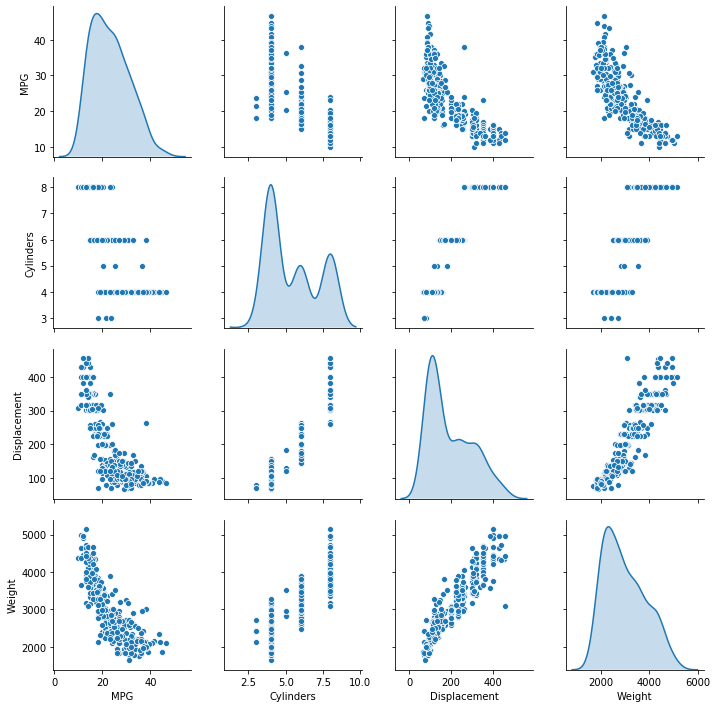

In [17]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Obviously we can make many inferences from looking at this data directly. There are a nu,ber of trends that are easily visible. We will alos now look at the aggregate stats for the dataset

In [18]:
train_stats = train_dataset.describe()
train_stats.pop("MPG") #removed mpg as this is what our labels are going to be
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [19]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

We can see from the stats above that the data has a very wide range of values. The magnitudes for each category are also reletively different. Therefore we may now want to normalize our data before we put it into the machine learning model. This has the main advantage of removing the models relianve on the units that are used in the model. 

In [20]:
def norm(x):
    return(x - train_stats['mean'])/train_stats['std']
normalized_train_data = norm(train_dataset)
normalized_test_data = norm(test_dataset)
normalized_train_data.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,-0.465148,-0.495225,0.774676
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,-0.465148,-0.495225,0.774676
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-0.465148,2.012852,-1.286751
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-0.465148,2.012852,-1.286751
182,-0.869348,-0.846517,-0.495310,-0.623596,-0.021237,0.027726,2.143005,-0.495225,-1.286751


## Building the model

Now that we have our data prepped, we can move on to building the actial model. We will again use the sequnetial model with two dense hidden layers and an output layer that will return our single continuous MPG value.

In [22]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    weights = model.get_weights()
    optimizer = tf.keras.optimizers.RMSprop(0.001) #
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae','mse']
    )

    return model, weights

In [23]:
model, weights = build_model()

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


## Training and Evaluating

Let's now train our model using the data that we prepared. We will train the model for 1000 epochs and then map its loss and validation accuracy over the epochs.


In [26]:
EPOCHS = 1000

history = model.fit(
    normalized_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[tfdocs.modeling.EpochDots()]
)


Epoch: 0, loss:564.9268,  mae:22.5171,  mse:564.9268,  val_loss:544.5377,  val_mae:22.0649,  val_mse:544.5377,  
....................................................................................................
Epoch: 100, loss:6.0825,  mae:1.7475,  mse:6.0825,  val_loss:9.0186,  val_mae:2.2618,  val_mse:9.0186,  
....................................................................................................
Epoch: 200, loss:5.4265,  mae:1.6140,  mse:5.4265,  val_loss:8.6918,  val_mae:2.2426,  val_mse:8.6918,  
....................................................................................................
Epoch: 300, loss:5.3423,  mae:1.5557,  mse:5.3423,  val_loss:8.8104,  val_mae:2.2039,  val_mse:8.8104,  
....................................................................................................
Epoch: 400, loss:4.6285,  mae:1.4257,  mse:4.6285,  val_loss:8.8311,  val_mae:2.2234,  val_mse:8.8311,  
..............................................................

Text(0, 0.5, 'MAE [MPG]')

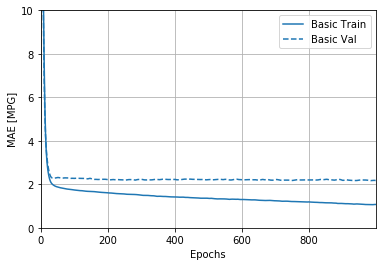

In [27]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

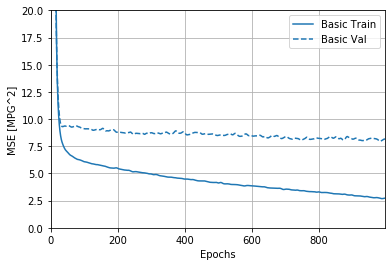

In [28]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

We can see that after epoch 100, the model does not really seem to improve at all, therefore we will create an automatic callback where the model will stop training once we stop seeing improvements.


In [29]:
model, weights = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normalized_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:555.0130,  mae:22.3265,  mse:555.0130,  val_loss:545.4239,  val_mae:22.0766,  val_mse:545.4240,  
....................................................................................................
Epoch: 100, loss:6.3438,  mae:1.7728,  mse:6.3438,  val_loss:8.7054,  val_mae:2.1585,  val_mse:8.7054,  
..................

Text(0, 0.5, 'MAE [MPG]')

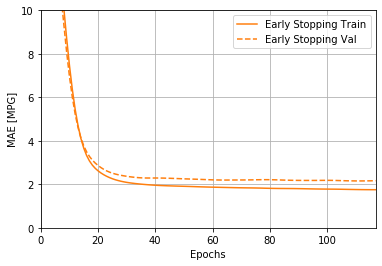

In [30]:
plotter.plot({"Early Stopping": early_history}, metric = 'mae')
plt.ylim([0,10])
plt.ylabel("MAE [MPG]")

MAE is the mean absolute error. Therefore, on average the error for the MPG is around +/- 2MPG. LEt us now see if our model generalizes well on our test set. This means that it produces the same results for our test set as well.

In [31]:
loss, mae, mse = model.evaluate(normalized_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.3818 - mae: 1.8326 - mse: 5.3818
Testing set Mean Abs Error:  1.83 MPG


Now we will see if our model even predicts well or not by comparing predicted values with the actual test values.


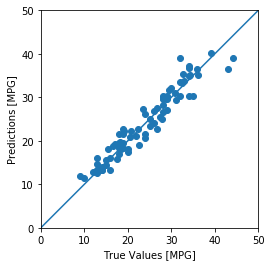

In [32]:
test_predictions = model.predict(normalized_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


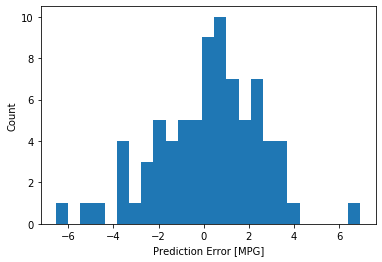

In [33]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")


In general it seems like we have a Gaussian prediction error. Therefore I'm gonna say that we did a pretty good job!